# 2CS-SIL2/SIQ2 Lab03. Decision trees (DTs) and Ensemle Learning

<p style='text-align: right;font-style: italic;'>Designed by: Mr. Abdelkrime Aries</p>

In this lab, we will learn all about decision trees and ensemble learning.



**Team:**
- **Member 01**: djihene guitoun
- **Member 02**: belgacem roza
- **Group**: SIL2

In [ ]:
import sys, timeit
from collections import OrderedDict
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

sys.version

'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

In [ ]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.26.4', '2.2.2', '3.10.0')

In [ ]:
import sklearn

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import SGDClassifier
# from sklearn.multiclass      import OneVsRestClassifier
# from sklearn.multiclass      import OneVsOneClassifier
from sklearn.metrics         import accuracy_score
# from sklearn.metrics         import classification_report
# from sklearn.metrics         import log_loss

from   sklearn.tree    import DecisionTreeClassifier
from   sklearn.metrics import f1_score
from   sklearn         import tree
from   sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble     import BaggingClassifier
from sklearn.ensemble     import AdaBoostClassifier
from sklearn.ensemble     import StackingClassifier


sklearn.__version__

'1.6.1'

In [ ]:
# This code is used to filter warnings concerning convergence
# In general, when the maximum number of iterations is not suffisant to converge
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [ ]:
!pip install graphviz
# Also you need to install the graphviz backend in the system
# Lien : https://graphviz.org/download/

## I. Algorithms implementation

In this section, we will try to implement ID3 and CART decision trees.

In [ ]:
# Dataset play
M=14
# outlook & temperature & humidity & windy
Xplay_cat = np.array([
    ['sunny'   , 'hot' , 'high'  , 'no'],
    ['sunny'   , 'hot' , 'high'  , 'yes'],
    ['overcast', 'hot' , 'high'  , 'no'],
    ['rainy'   , 'mild', 'high'  , 'no'],
    ['rainy'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'cool', 'normal', 'yes'],
    ['overcast', 'cool', 'normal', 'yes'],
    ['sunny'   , 'mild', 'high'  , 'no'],
    ['sunny'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'mild', 'normal', 'no'],
    ['sunny'   , 'mild', 'normal', 'yes'],
    ['overcast', 'mild', 'high'  , 'yes'],
    ['overcast', 'hot' , 'normal', 'no'],
    ['rainy'   , 'mild', 'high'  , 'yes']
])

# temperature & humidity & windy
Xplay_num = np.array([
    [30, 85, 0],
    [27, 90, 1],
    [28, 78, 0],
    [21, 96, 0],
    [20, 80, 0],
    [18, 70, 1],
    [18, 65, 1],
    [22, 95, 0],
    [21, 70, 0],
    [24, 80, 0],
    [24, 70, 1],
    [22, 90, 1],
    [27, 75, 0],
    [22, 80, 1]
])


Yplay = np.array([
    'no',
    'no',
    'yes',
    'yes',
    'yes',
    'no',
    'yes',
    'no',
    'yes',
    'yes',
    'yes',
    'yes',
    'yes',
    'no'
])

Xplay_cat.shape, Xplay_num.shape, Yplay.shape

((14, 4), (14, 3), (14,))

### I.1. Probability of a category

Given:
- $c$: a given nominal value (category)
- $A[M]$: values of a categorical attribute

the probability of this value is calculated as:

$$p(c \in A) = \frac{|\{a\, |\, a \in A \wedge a = c\}|}{|A|}$$


**>> P.S. If the division always returns 0, try applying float(x) on integer numbers**

In [ ]:
# TODO: Probability of a category
def p_cat(c: str, A: np.ndarray) -> float:
    return np.count_nonzero(A == c) / A.size

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (0.6428571428571429,
#  0.35714285714285715,
#  0.2857142857142857,
#  0.35714285714285715)
#---------------------------------------------------------------------

p_cat('yes'     , Yplay      ), \
p_cat('sunny'   , Xplay_cat[:, 0]), \
p_cat('overcast', Xplay_cat[:, 0]), \
p_cat('rainy'   , Xplay_cat[:, 0])

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

### I.2. Homogeneity of a set


#### I.2.1. Shannon's entropy

Given:
- $A[M]$: values of a categorical attribute
- $V$: a set of unique categories of $A$ (vocabulary)

Shannon's entropy is calculated as:
$$H(A) = - \sum\limits_{c \in V} p(c \in A) \log_2 p(c \in A)$$


**>> P.S. np.log2 calculate log2 of a scalar, vector or matrix**

In [ ]:
# TODO: Shannon's entropy
def shannon_entropy(A: np.ndarray) -> float:
    h = np.unique(A)
    entropy = 0
    for v in  h:
        p = p_cat(v,A)
        entropy = entropy - (p * np.log2(p))
    return entropy


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (0.9402859586706311, 1.5774062828523454, 1.5566567074628228)
#---------------------------------------------------------------------

shannon_entropy(Yplay), \
shannon_entropy(Xplay_cat[:, 0]), \
shannon_entropy(Xplay_cat[:, 1])

(0.9402859586706311, 1.5774062828523454, 1.5566567074628228)

#### I.2.2. Gini diversity index (Gini impurity)

Given:
- $A[M]$: values of a categorical attribute
- $V$: a set of unique categories of $A$ (vocabulary)

Gini impurity is calculated by:
$$Gini(A) = \sum\limits_{c \in V} p(c \in A) (1-p(c \in A)) = 1 - \sum\limits_{c \in V} p(c \in A)^2 $$

In [ ]:
# TODO: Gini impurity
def gini_impurity(A: 'np.ndarray[M](str)') -> float:
    gini = 1.
    p=0
    h = np.unique(A)
    for v in h:
        p=p+np.square(p_cat(v,A))
    return gini-p


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 0.4591836734693877
#---------------------------------------------------------------------

gini_impurity(Yplay)

0.4591836734693877

### I.3. Set splitting

**>> Nothing to code here**

#### I.3.1. ID3's set splitting

Given:
- $Y[M]$: values of the output attribute,
- $A[M]$: values of a categorical attribute,
- $c$: a given nominal value (category) of $A$;

$Y$ is split as:
$$Y_{c \in A} = \{y^{(i)} \in Y\, |\, a^{(i)} \in A \wedge a^{(i)} = c\}$$


In [ ]:
def split_ID3(c: str,
              A: 'np.ndarray[M](str)',
              Y: 'np.ndarray[M](str)'
              ) -> 'np.ndarray(str)':
    msk = A == c
    return Y[msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')
#---------------------------------------------------------------------

split_ID3('sunny', Xplay_cat[:,0], Yplay)

array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')

#### I.3.2. CART's set splitting

Given:
- $Y[M]$: values of the output attribute,
- $A[M]$: values of a numerical attribute,
- $v$: a given numerical value of $A$;


$Y$ is split as:
- $Y_L$: a subset of $Y$ where $A > v$
- $Y_R$: a subset of $Y$ where $A \le v$

In [ ]:
def split_CART(v: float,
               A: 'np.ndarray[M](float)',
               Y: 'np.ndarray[M](str)'
               ) -> Tuple['np.ndarray(str)', 'np.ndarray(str)']:
    msk = A > v
    return Y[msk], Y[~msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
#         'no'], dtype='<U3'),
#  array(['yes', 'no', 'yes'], dtype='<U3'))
#---------------------------------------------------------------------

split_CART(20, Xplay_num[:,0], Yplay)

(array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
        'no'], dtype='<U3'),
 array(['yes', 'no', 'yes'], dtype='<U3'))

### I.4. Choice of split feature

#### I.4.1. Information gain

Given:
- $Y[M]$: values of the output attribute,
- $A[M]$: values of a numerical attribute,
- $V$: a set of unique categories of $A$ (vocabulary),

Informtion gain is calculated as:
$$IG(A, Y) = H(Y) - \sum_{c \in V} p(c \in A) H(Y_{c \in A})$$

**>> The function must return a tuple (Information gain, entropy)**

In [ ]:
# TODO: Information gain
def information_gain(A: 'np.ndarray[M](str)',
                     Y: 'np.ndarray[M](str)'
                     ) -> Tuple[float, float]:
    h  = shannon_entropy(Y)
    ig = h
    for v in np.unique(A):
        ig=ig-p_cat(v,A)*shannon_entropy(split_ID3(v,A,Y))
    return ig, h

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# ((0.24674981977443933, 0.9402859586706311),
#  (0.02922256565895487, 0.9402859586706311),
#  (0.15183550136234164, 0.9402859586706311),
#  (0.048127030408269544, 0.9402859586706311))
#---------------------------------------------------------------------

information_gain(Xplay_cat[:, 0], Yplay),\
information_gain(Xplay_cat[:, 1], Yplay),\
information_gain(Xplay_cat[:, 2], Yplay),\
information_gain(Xplay_cat[:, 3], Yplay)
information_gain(Yplay,Xplay_cat[:,0])

(0.24674981977443933, 1.5774062828523454)

#### I.4.2. Gini impurity of the split

Given:
- $Y[M]$: values of the output attribute,
- $Y_L, Y_R$: to subsets of $Y$ where $Y_L \cup Y_R = Y$;

Gini impurity of the split is calculated as:

$$Gini_{split}(Y_L, Y_R) = \frac{|Y_L|}{|Y|} Gini(Y_L) + \frac{|Y_R|}{|Y|} Gini(S_R)$$


In [ ]:
# TODO: Gini impurity of the split
def gini_split(Y_L: 'np.ndarray(str)', Y_R: 'np.ndarray(str)') -> float:
    gini_split = Y_L.size * gini_impurity(Y_L) + Y_R.size * gini_impurity(Y_R)
    gini_split = gini_split / (Y_L.size + Y_R.size)
    return gini_split

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 0.4588744588744589
#---------------------------------------------------------------------

gini_split(*split_CART(20, Xplay_num[:, 0], Yplay))

0.4588744588744588

### I.5. Splitting feature selection

#### I.5.1. ID3 splitting feature selection

Given:
- $X[M, N]$: a matrix of $M$ samples and $N$ categorical features,
- $Y[M]$: a vector of output labels;

We want to find the feature which maximizes:

$$\hat{j} = \arg\max_j IG(Y, X_j)$$

This function must return:
- $\hat{j}$: the index of the best feature
- $IG(Y, X_{\hat{j}})$: its information gain
- $H(Y)$: the entropy

In [ ]:
# TODO: ID3 splitting feature selection
def choose_split_ID3(X: 'np.ndarray[M, N](str)',
                     Y: 'np.ndarray[Y](str)'
                     ) -> Tuple[int, float, float]:
    bestj    = -1   # number of the best feature
    ig_bestj = -1.0 # IG of the best feature
    h_bestj  = -1.0 # Entropy of the best feature
    for j in range(X.shape[1]):
        [ig,enthropy]=information_gain(X[:,j],Y)
        if(ig>ig_bestj):
            ig_bestj=ig
            h_bestj=enthropy
            bestj=j
    return bestj, ig_bestj, h_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (0, 0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

choose_split_ID3(Xplay_cat, Yplay)

(0, 0.24674981977443933, 0.9402859586706311)

#### I.5.2. CART splitting feature and value selection

Given:
- $X[M, N]$: a matrix of $M$ samples and $N$ categorical features,
- $Y[M]$: a vector of output labels;

We want to find the feature and its value which minimize Gini impurity for the split.

Algorithm:
- For each feature $X_j$
   - For each value $v \in unique(X_j)$
       1. Split $Y$ given $X_j$ and $v$
       1. Calculate Gini diversity of the division
       1. If its value is less than the last one, save it along with $j$ as $\hat{j}$, $v$ as $\hat{v}$

This function must return:
- $\hat{j}$: the index of the best feature
- $\hat{v}$: the value of the best feature
- $Gini_{split}/\hat{j}, \hat{v}$: the split Gini based on the best feature and its value

In [ ]:
# TODO: CART splitting feature and value selection
def choose_split_CART(X: 'np.ndarray[M, N](float)',
                      Y: 'np.ndarray[Y](str)'
                      ) -> Tuple[int, float, float]:
    bestj      = -1
    gini_bestj =  1.0
    v_bestj    = -1.0
    for j in range(X.shape[1]):
        for v in np.unique(X[:,j]):
            [Y_L,Y_R]=split_CART(v,X[:,j],Y)
            gini=gini_split(Y_L,Y_R)
            if(gini<gini_bestj):
                gini_bestj=gini
                v_bestj=v
                bestj=j
    return bestj, v_bestj, gini_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (1, 80, 0.3936507936507937)
#---------------------------------------------------------------------

choose_split_CART(Xplay_num, Yplay)

(1, 80, 0.39365079365079364)

### I.6. Stopping criterion

Given:
- $Y$: a set of outupt labels in a given node
- $h$: the homogeneity criterion. h = 0 ==> the set Y is homogeneous (same values)
- $nbr\_min$: the minimum number of samples in a node. |Y| <= nbr_min ==> the node must be a leaf

the function must return:
- The name of the class: if the set is homogeneous or it contains a minimum number of elements
- None: otherwise

**>> HINT: use numpy.unique and numpy.argmax**

In [ ]:
# TODO: Stopping criterion
def stop(Y: np.ndarray, h: float, nbr_min: int) -> Union[str, None]:
    V = np.unique(Y)
    if h ==0:
        return Y[0]
    if Y.size <= nbr_min:
        nb_v = [np.count_nonzero(Y == v) for v in V]
        return V[np.argmax(nb_v)]

    return None

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# ('yes', 'no', None, 'yes', 'no', None)
#---------------------------------------------------------------------

Y_t1 = np.array(['yes', 'yes', 'yes'])
Y_t2 = np.array(['yes', 'no', 'no'])

stop(Y_t1, shannon_entropy(Y_t1), 2), \
stop(Y_t2, shannon_entropy(Y_t2), 4), \
stop(Y_t2, shannon_entropy(Y_t2), 2), \
stop(Y_t1, gini_impurity(Y_t1), 2), \
stop(Y_t2, gini_impurity(Y_t2), 4), \
stop(Y_t2, gini_impurity(Y_t2), 2)

('yes', 'no', None, 'yes', 'no', None)

### I.7. Final product

**>> Nothing to code here**

#### I.7.1. Tree structure and prediction

In [ ]:
# A class to represent a node
class Node(object):

    nbr = 0

    def __init__(self, test: Union[int, Tuple[int, float]], depth:int=0, info:str=''):
        self.test     = test          # test creteria the number of the feature (+ the value)
        self.depth    = depth         # the depth of the noade
        self.children = OrderedDict() # the children: a dictionary of value: node
        self.cls      = ''            # the class if the node is a leaf
        self.indent   = '    '        # indentation hen generating the code
        self.info     = info

    # Transform the node to a string
    def __str__(self):

        indent = self.indent * self.depth # indentation

        # if no children, the node is a leaf; print the class
        if (len(self.children) == 0):
            return indent + 'return "' + self.cls + '"\n'

        if isinstance(self.test, int):
            tst1, tst3 = str(self.test) + '] == "', '"'
        else:
            tst1, tst3 = str(self.test[0]) + '] ', ''
        tst1 = 'if X[' + tst1

        # if there are children, print IF conditions
        i, l = 0, len(self.children) - 1
        res = ""
        for f_v, n_v in self.children.items():
            tst2 = str(f_v)
            if i == l:
                tst1, tst2, tst3 = 'else', '', ''
            elif i > 0:
                tst1 = 'el' + tst1
            res += indent + tst1 + tst2 + tst3 + ':\n' + str(n_v)
            i += 1

        return res

    # predict a sample
    def predict(self, x: List[str]) -> str:

        # If the node is final, return its class
        if (len(self.children) == 0):
            return self.cls

        # ID3
        if isinstance(self.test, int):
            # If the value of this node's feature is not in its children
            # return np.nan
            if x[self.test] not in self.children:
                return np.nan

            # Otherwise, it returns the prediction of the child
            return self.children[x[self.test]].predict(x)

        # CART
        if x[self.test[0]] > self.test[1]:
            return self.children.items[0][1].predict(x)
        return self.children.items[1][1].predict(x)

    def graphviz(self):

        nid = 'N' + str(Node.nbr)
        Node.nbr += 1

        if (len(self.children) == 0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'

        j = self.test if isinstance(self.test, int) else self.test[0]

        res  = nid + '[label="X[' + str(j) + ']\\n'
        res += self.info
        for f in self.children:
            vid, code = self.children[f].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + f + '"];\n'
        return nid, res

#=====================================================================
# UNIT TEST
#=====================================================================
# The code
# 'return "c1"\n'
#---------------------------------------------------------------------

nn = Node(test=5)
nn.cls = 'c1'
str(nn)

'return "c1"\n'

#### I.7.2. Tree construction (training)

In [ ]:
def fit_ID3(X: 'np.ndarray[M, N]',
            Y: 'np.ndarray[M]',
            nbr_min: int = 0,
            depth : int = 0
            ) -> Node:

    j, ig, h = choose_split_ID3(X, Y)
    info = 'H = {:.5f}\\nIG = {:.5f}"];\n'.format(h, ig)
    node = Node(j, depth=depth, info=info)
    c = stop(Y, h, nbr_min)
    if c:
        node.cls = c
        return node

    depth += 1
    for v in np.unique(X[:, j]):
        msk = X[:, j] == v
        X_v = X[msk]
        Y_v = Y[msk]
        child = fit_ID3(X_v, Y_v, nbr_min=nbr_min, depth=depth)
        node.children[v] = child

    return node

#=====================================================================
# UNIT TEST
#=====================================================================
# The code
# if X[0] == "overcast":
#     return "yes"
# elif X[0] == "rainy":
#     if X[3] == "no":
#         return "yes"
#     else:
#         return "no"
# else:
#     if X[2] == "high":
#         return "no"
#     else:
#         return "yes"

# 'yes'
#---------------------------------------------------------------------

tree_cat = fit_ID3(Xplay_cat, Yplay)

print('The code')
print(tree_cat)

# Test a sample
tree_cat.predict(['rainy', 'temperature_makanche', 'humidity_makanche', 'no'])

The code
if X[0] == "overcast":
    return "yes"
elif X[0] == "rainy":
    if X[3] == "no":
        return "yes"
    else:
        return "no"
else:
    if X[2] == "high":
        return "no"
    else:
        return "yes"



'yes'

In [ ]:
def fit_CART(X: 'np.ndarray[M, N]',
             Y: 'np.ndarray[M]',
             nbr_min: int = 0,
             depth : int = 0
             ) -> Node:

    j, v, gini = choose_split_CART(X, Y)
    info = 'Gini = {:.5f}"];\n'.format(gini)
    node = Node((j, v), depth=depth, info=info)

    c = stop(Y, gini, nbr_min)
    if c:
        node.cls = c
        return node

    depth += 1

    msk = X[:, j] > v

    X_L = X[msk]
    Y_L = Y[msk]
    child_L = fit_CART(X_L, Y_L, nbr_min=nbr_min, depth=depth)
    X_R = X[~msk]
    Y_R = Y[~msk]
    child_R = fit_CART(X_R, Y_R, nbr_min=nbr_min, depth=depth)
    node.children['> ' + str(v)] = child_L
    node.children['<= ' + str(v)] = child_R

    return node

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# The Code
# if X[1] > 80:
#     if X[0] > 22:
#         return "no"
#     else:
#         if X[0] > 21:
#             return "no"
#         else:
#             return "yes"
# else:
#     if X[2] > 0:
#         if X[1] > 70:
#             return "no"
#         else:
#             if X[0] > 18:
#                 return "yes"
#             else:
#                 return "no"
#     else:
#         return "yes"
#---------------------------------------------------------------------

tree_num = fit_CART(Xplay_num, Yplay)

print('The Code')
print(tree_num)

The Code
if X[1] > 80:
    if X[0] > 22:
        return "no"
    else:
        if X[0] > 21:
            return "no"
        else:
            return "yes"
else:
    if X[2] > 0:
        if X[0] > 22:
            return "yes"
        else:
            return "no"
    else:
        return "yes"



#### I.7.3. Decision tree class

In [ ]:
class DT(object):

    def __init__(self, num=False):
        if num:
            self.fit_fct = fit_CART
        else:
            self.fit_fct = fit_ID3

    def fit(self,
            X: 'np.ndarray[M, N]',
            Y: 'np.ndarray[M]',
            features: List[str] = [],
            clsname:str = '',
            nbr_min:int = 0):

        self.tree = self.fit_fct(X, Y, nbr_min=nbr_min, depth=0)
        code = str(self.tree)
        if len(clsname) > 0:
            code = code.replace('Y', clsname)
        for i in range(len(features)):
            code = code.replace('X[' + str(i) + ']', features[i])
        self.code   = code
        self.features = features

    def predict(self, x:np.ndarray):
        predictions = []
        for i in range(len(x)):
            predictions.append(self.tree.predict(x[i, :]))
        return predictions

    def graphviz(self):
        nid, code = self.tree.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.features)):
            code = code.replace('X[' + str(i) + ']', self.features[i])
        res += code
        res += '}'
        return res

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# ID3
# -------------
# if outlook == "overcast":
#     return "yes"
# elif outlook == "rainy":
#     if windy == "no":
#         return "yes"
#     else:
#         return "no"
# else:
#     if humidity == "high":
#         return "no"
#     else:
#         return "yes"

# CART
# -------------
# if temperature > 80:
#     if outlook > 22:
#         return "no"
#     else:
#         if outlook > 21:
#             return "no"
#         else:
#             return "yes"
# else:
#     if humidity > 0:
#         if temperature > 70:
#             return "no"
#         else:
#             if outlook > 18:
#                 return "yes"
#             else:
#                 return "no"
#     else:
#         return "yes"
#---------------------------------------------------------------------

features=['outlook', 'temperature', 'humidity', 'windy']

id3_classifier = DT()
id3_classifier.fit(Xplay_cat, Yplay, features=features, clsname='play')

cart_classifier = DT(num=True)
cart_classifier.fit(Xplay_num, Yplay, features=features, clsname='play')

print('ID3')
print('-------------')
print(id3_classifier.code)
print('CART')
print('-------------')
print(cart_classifier.code)

ID3
-------------
if outlook == "overcast":
    return "yes"
elif outlook == "rainy":
    if windy == "no":
        return "yes"
    else:
        return "no"
else:
    if humidity == "high":
        return "no"
    else:
        return "yes"

CART
-------------
if temperature > 80:
    if outlook > 22:
        return "no"
    else:
        if outlook > 21:
            return "no"
        else:
            return "yes"
else:
    if humidity > 0:
        if outlook > 22:
            return "yes"
        else:
            return "no"
    else:
        return "yes"



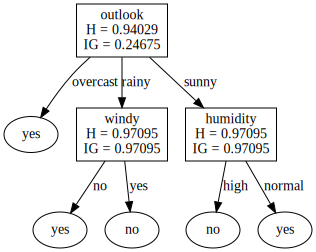

In [ ]:
# It's just a visualization of the graph
# If it doesn't work, it doesn't matter
try:
    from IPython.display import SVG
    from graphviz        import Source
    from IPython.display import display

    graph = Source(id3_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

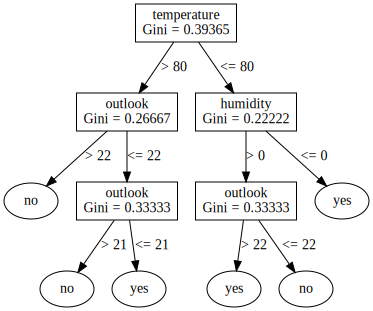

In [ ]:
# It's just a visualization of the graph
# If it doesn't work, it doesn't matter
try:
    from IPython.display import SVG
    from graphviz        import Source
    from IPython.display import display

    graph = Source(cart_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it.
We will use [Cars Data](https://www.kaggle.com/abineshkumark/carsdata) just for 3 classes: US., Euroupe. and Japan.

In [ ]:
# Dataset import
cars_data = pd.read_csv('data/cars.csv', skipinitialspace=True)
# Remove missing values
cars_data.dropna(inplace=True)
# Yay! We did it! These are the first samples
cars_data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,US.
1,31.9,4,89.0,71,1925.0,14,1980,Europe.
2,17.0,8,302.0,140,3449.0,11,1971,US.
3,15.0,8,400.0,150,3761.0,10,1971,US.
4,30.5,4,98.0,63,2051.0,17,1978,US.


In [ ]:
cars_data.dtypes

,0
mpg,float64
cylinders,int64
cubicinches,float64
hp,int64
weightlbs,float64
time-to-60,int64
year,int64
brand,object


In [ ]:
X_cars = cars_data.values[:, :-1]
Y_cars = cars_data.values[:,  -1]

X_cars_train, X_cars_test, Y_cars_train, Y_cars_test = train_test_split(X_cars,
                                                                        Y_cars,
                                                                        test_size=0.2,
                                                                        random_state=0)

X_cars_train.shape, X_cars_test.shape

((204, 7), (52, 7))

[texte du lien](https://)### II.1. Decision trees and Random forests

We want to test the effect of different hyper-parameters of decision trees.


In Scikit-learn's implemtation (**DecisionTreeClassifier**), features are always randomly permuted at each split.
The tree will be undeterministic (which is good for overfitting, but not good for tessting the effect of hyper-parameters).
In this case, we stop this property using **random_state=0**.

#### II.1.1. Feature selection criteria

In scikit-learn, there is only CART which can use both:
1. Entropy
1. Gini

Both will generate slightly different decision tree structures. We want to test the effect of the structure on training and test.

In [ ]:
Xtrain = X_cars_train
Ytrain = Y_cars_train
Xtest  = X_cars_test
Ytest  = Y_cars_test
fnames = cars_data.columns


gini_stats         = []
entropy_stats      = []
gini_classifier    = DecisionTreeClassifier(criterion='gini'   , random_state=0, min_samples_leaf=7)
entropy_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0, min_samples_leaf=7)

# ============ GINI ====================
# ................ Train ..............
temps_debut = timeit.default_timer()
gini_classifier.fit(Xtrain, Ytrain)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train .........
gini_stats.append(f1_score(Ytrain, gini_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = gini_classifier.predict(Xtest)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
gini_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

# =========== Entropy ==================
# ............ Train ............
temps_debut = timeit.default_timer()
entropy_classifier.fit(Xtrain, Ytrain)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train ........
entropy_stats.append(f1_score(Ytrain, entropy_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = entropy_classifier.predict(Xtest)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
entropy_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

print('Fin')

Fin


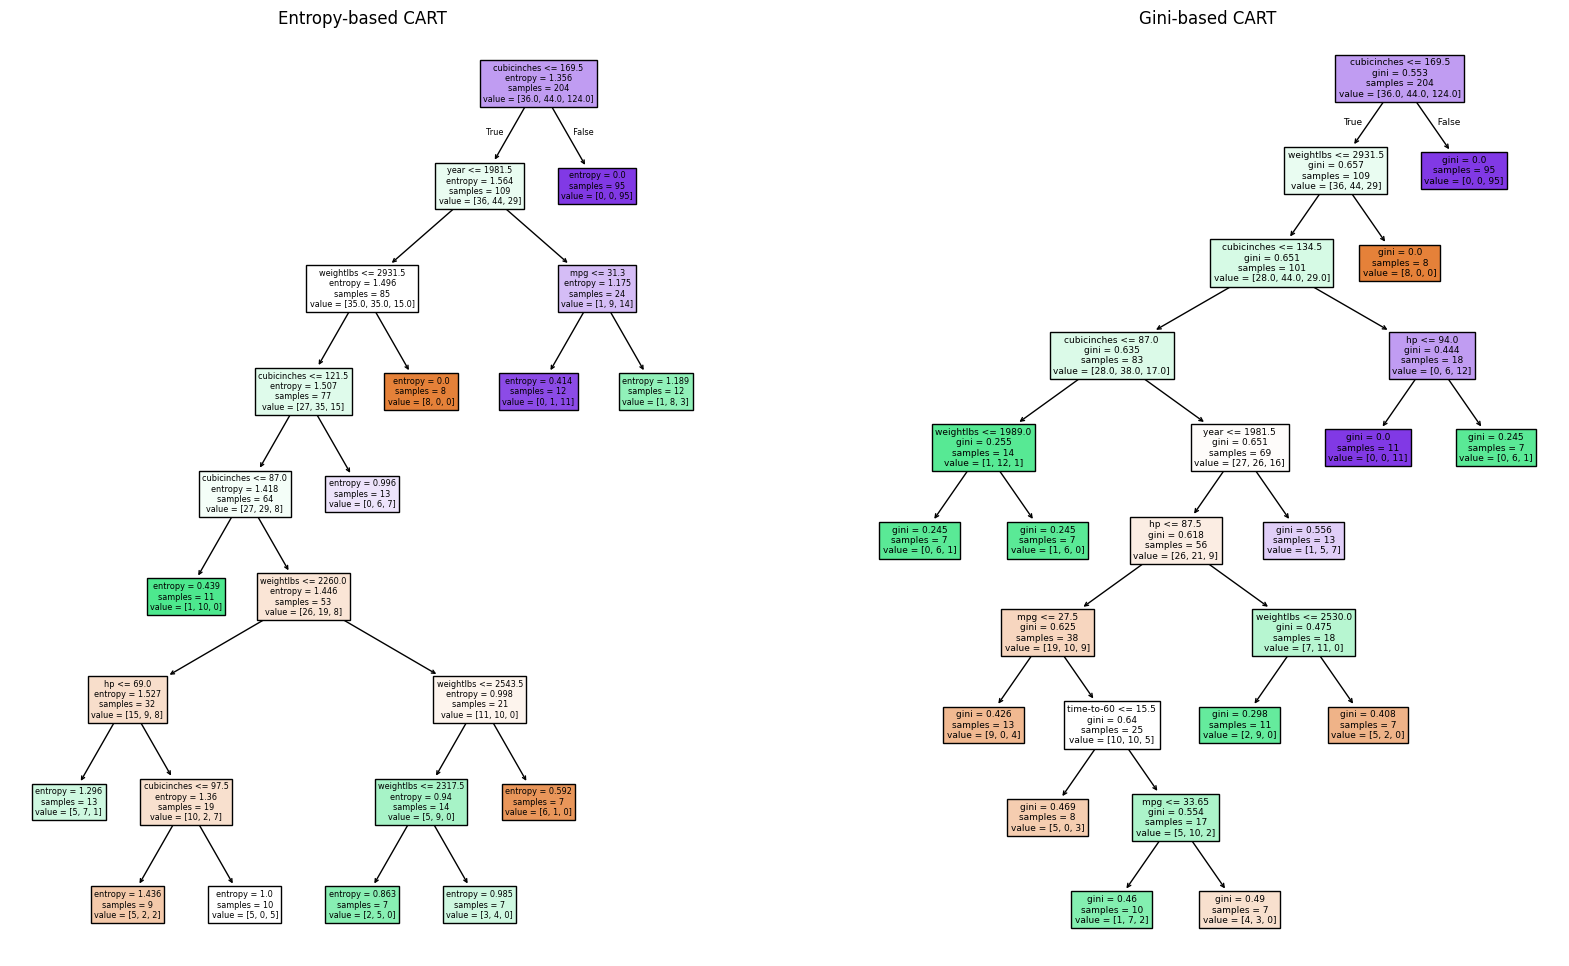

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth (20)
fig.set_figheight(12)
tree.plot_tree(entropy_classifier, ax=ax1, feature_names=fnames, filled=True)
tree.plot_tree(gini_classifier   , ax=ax2, feature_names=fnames, filled=True)
ax1.set_title('Entropy-based CART')
ax2.set_title('Gini-based CART')
plt.show()

In [ ]:
pd.DataFrame({
    'Criteria' : ['Train Time', 'Train F1', 'Test Time', 'Test F1'],
    'Entropy-based CART' : entropy_stats,
    'Gini-based CART'    : gini_stats
})

,Criteria,Entropy-based CART,Gini-based CART
0,Train Time,0.004157,0.026255
1,Train F1,0.838235,0.872549
2,Test Time,0.000819,0.000691
3,Test F1,0.788462,0.807692


**TODO: Analyze the results**

1. Compare the two trees' structures (depth, leafs number, position of leafs)
1. Justify the training time based on the algorithms and trees structures
1. Justify the test time based on the algorithms and trees structures

**Answers**

1.

**Depth:**

-Entropy-based CART: The tree appears to have a maximum depth of 5.

-Gini-based CART: The tree appears to have a maximum depth of 6.

**Number of Leafs:**

-Entropy-based CART: The tree has 13 leaf nodes.

-Gini-based CART: The tree has 16 leaf nodes.


**Position of Leafs:**

-Entropy-based CART: The leaf nodes are distributed more evenly across the tree, with fewer splits leading to deeper levels.

-Gini-based CART: The leaf nodes are more concentrated at deeper levels, indicating more splits and a more complex structure.


2.

**Training Time:**
Gini-based CART took longer to train

Entropy-based CART: 0.004157 s

Gini-based CART: 0.026255 s

This is due to the following factors:

-Complexity of the Tree: The Gini-based CART has a deeper structure and more leaf nodes==> 25 which requires more computational effort to build.

-Criterion Calculation: The Gini impurity calculation might be more computationally compared to entropy especially when dealing with a larger number of splits.

-Number of Splits: The Gini-based CART performs more splits leading to a higher number of nodes and consequently more time to train.


3.

**Test Time:**

Entropy-based CART: 0.000819 s

Gini-based CART: 0.000691 s

==>quite similar, but the Gini-based CART is slightly faster.

This can be explained by:

-the prediction process involves traversing the tree from the root to a leaf node, which is relatively fast, and as we know that the difference in depth between the two trees is not big that it can cause a big difference in test time
    




#### II.1.2. Maximum depth

We want to test the effect of stopping creteria "maximum depth", so we used F1 score as classification quality measure.

For each maximum depth, we trained a decision/random forest tree and calculated its F1 score on training data (to test convergence) and on test data (to test generalization).

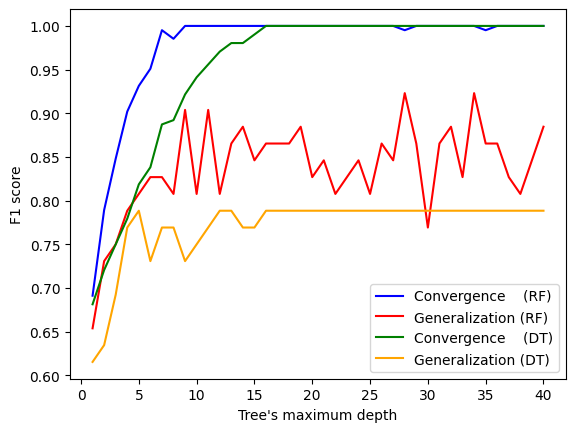

In [ ]:
MAX_DEPTH     = 40
MAX_DEPTH_lst = range(1, MAX_DEPTH+1, 1)

f1_trn_md_DT  = []
f1_tst_md_DT  = []
f1_trn_md_RF  = []
f1_tst_md_RF  = []
for max_depth in MAX_DEPTH_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_md_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_md_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, max_depth=max_depth)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_md_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_md_RF.append (f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MAX_DEPTH_lst, f1_trn_md_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_RF, color='red'   , label='Generalization (RF)')
plt.plot(MAX_DEPTH_lst, f1_trn_md_DT, color='green' , label='Convergence    (DT)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s maximum depth')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**

1. Why F1 score (convergence) is not enhanced after depth=17 in decision trees (DT)?
1. Why F1 score (Generalization) is not enhanced after depth=17 in decision trees (DT)?
1. Why Random forests (RF) converge better then decision trees (DT) with less maximum depth?
1. Why Random forests (RF) generalize better then decision trees (DT)?

**Answers**

1. After depth=17, the F1 score for decision trees stops improving because the tree starts to overfit the training data. This means it captures noise and specific details that don't help in improving the model's performance. after this point, adding more depth just makes the model too complex without providing significant new insights, so the F1 score plateaus.
1. The F1 score for generalization doesn't improve after depth=17 in decision trees because the model becomes too complex and overfits the training data. This overfitting makes the tree sensitive to the training data's noise, leading to poor performance on new, unseen data. As a result, the F1 score on the test data doesn't get better and may even decrease.
1. Random forests  converge better than decision trees  with less maximum depth because they use an ensemble of trees. Each tree in the forest is trained on different data subsets, which reduces overfitting and captures more general patterns. This ensemble approach makes RF more robust and helps it achieve better convergence on the training data even with shallower trees.
1. Random forests generalize better than decision trees  because they combine predictions from multiple trees, reducing variance and overfitting. This ensemble method makes RF more stable and reliable on new data. Additionally, the diversity in the trees, trained on different data subsets, helps RF capture a broader range of patterns, improving generalization compared to a single decision tree.

#### II.1.3. Minimum leaf samples

We want to test the effect of stopping creteria "mimimum samples in leafs", so we used F1 score as classification quality measure.

For each minimum leaf samples number, we trained a decision tree/random forest and calculated its F1 score on training data (to test convergence) and on test data (to test generalization).

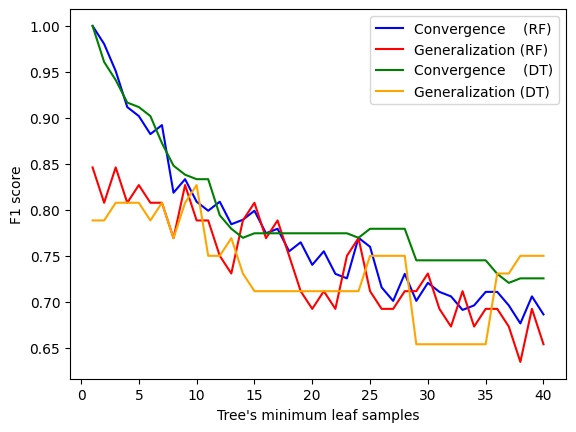

In [ ]:
MIN_LEAF    = 40
MIN_LEAF_lst = range(1, MIN_LEAF+1, 1)

f1_trn_ml_DT = []
f1_tst_ml_DT = []
f1_trn_ml_RF = []
f1_tst_ml_RF = []
for min_samples_leaf in MIN_LEAF_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_samples_leaf)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_ml_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, min_samples_leaf=min_samples_leaf)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_ml_RF.append(f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MIN_LEAF_lst, f1_trn_ml_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_RF, color='red'   , label='Generalization (RF)')
plt.plot(MIN_LEAF_lst, f1_trn_ml_DT, color='green' , label='Convergence    (DT)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s minimum leaf samples')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why F1 score of decision trees (DT) gets worst when increasing the minimum leaf samples?
1. Why F1 score of decision trees (DT) gets better then random forests when increasing the minimum leaf samples?

**Answers**

1. when the leaf samples increase, decision trees become more constrained and less flexible, This last prevents the tree from capturing  details , leading to underfitting. Underfitting occurs when the model is too simple to capture the complexity of the data wich will resulting in poor performance on both training and test datasets. so, the F1 score decreases because the model fails to  classify right the data.
1. When the minimum leaf samples increase, decision trees become simpler wich  can sometimes lead to better generalization on the test data compared to random forests , which might still capture some noise due to their ensemble nature. in addition, with very high minimum leaf samples, random forests may struggle to maintain diversity among the trees, leading to a decrease in their performance. but in other side we have decision trees, being simpler, can sometimes perform better in such constrained scenarios.


### II.2. Ensemle Learning

Random forests are just bagging over decision trees.
We want to test different hyper-parameters of ensemble learning.

#### II.2.1. Estimators' number

We want to test the effect of estimators' number in both AdaBoost and Bagging.
We applied these two ensemble learning techniques on decision trees and logistic regression.

In [ ]:
MAX_ESTIMATORS     = 50
MAX_ESTIMATORS_lst = range(1, MAX_ESTIMATORS+1, 1)

mdls = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_perf = {}
for mdl_name, mdl in mdls:
    mdls_perf[mdl_name] = {'bagging': [], 'boosting': []}

for n_estimators in MAX_ESTIMATORS_lst:
    for mdl_name, mdl in mdls:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=n_estimators)
        mdl_boosting = AdaBoostClassifier(estimator=mdl, n_estimators=n_estimators, algorithm='SAMME')

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_perf[mdl_name]['bagging'].append(accuracy_score(Y_cars_test, Y_pred))


        mdl_boosting.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_boosting.predict(X_cars_test)
        mdls_perf[mdl_name]['boosting'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


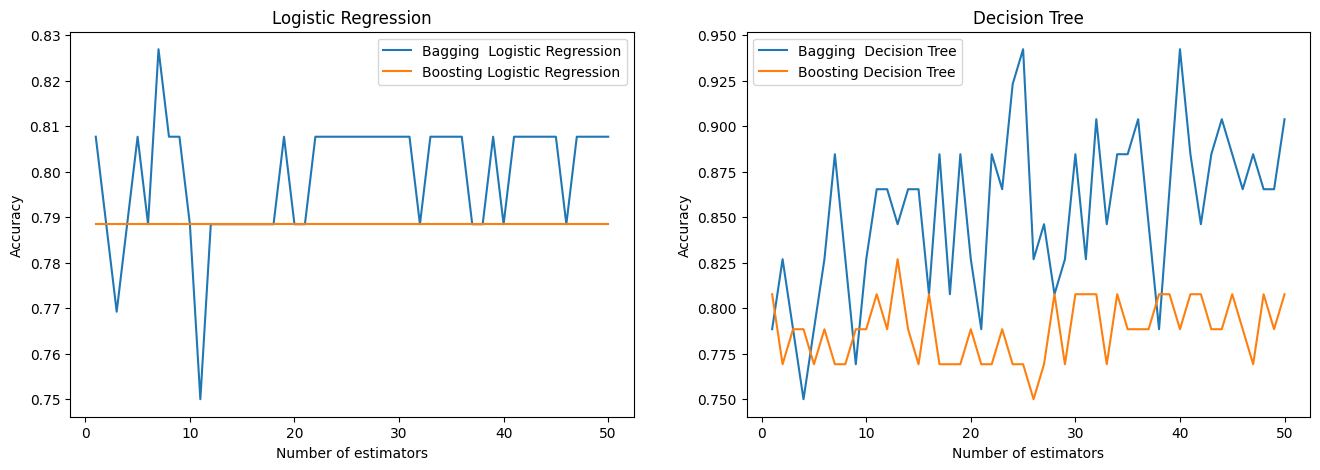

In [ ]:
fig, axs = plt.subplots(1, len(mdls), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls):
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['bagging' ], label='Bagging  ' + mdl_name)
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['boosting'], label='Boosting ' + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Number of estimators')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why Bagging is better than boosting in this experiment (according to the data)?
1. Propose a logical hypothesis to why Logistic Regression does not improve using boosting.
1. Why bagging is enhancing accuracy using decision trees?
1. Why boosting is not enhancing accuracy as much as bagging using decision trees?

**Answers**

1.One key advantage of bagging is its ability to handle noisy data and outliers effectively. Since the ensemble model aggregates predictions from multiple.The dataset contains noise or outliers, and Boosting tends to overfit such data due to its focus on hard-to-classify samples. Bagging, on the other hand, averages multiple learners trained on random subsets, which helps reduce variance and avoid overfitting.

2.Logistic Regression doesn’t benefit from Boosting because it's already a low-variance, high-bias model. Boosting focuses on reducing bias, but there’s not much bias to reduce in Logistic Regression in this case. Also, Boosting tends to work better with weak learners like decision stumps—not with models like Logistic Regression which are already strong and stable on their own.

3.Bagging helps Decision Trees because they are high-variance models.The decision is calculated based on the average of all the outputs of each tree  trained on bootstrapped samples, that helps stabilizing  the predictions and increases generalization, improving test accuracy significantly.

4.Boosting doesn’t help Decision Trees as much here because it can cause overfitting, especially if the trees are deep or the dataset is noisy. Boosting emphasizes misclassified points, which might include mislabeled or noisy data, and this misguides the model.

#### II.2.2. Bootstrap's size

In this expreiment, we are interested in bagging; more precisely, Bootstrap's size.

*P.S. We used SGD instead of linear logistic regression because this latter has some problems with bagging*

In [ ]:
BAG_PERC_lst = np.arange(0.1, 1, 0.01)

mdls_bag = [
    ('Logistic Regression', SGDClassifier()),
    # ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_bag_perf = {}
for mdl_name, mdl in mdls_bag:
    mdls_bag_perf[mdl_name] = {'train': [], 'test': []}

for max_samples in BAG_PERC_lst:
    for mdl_name, mdl in mdls_bag:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=20, max_samples=max_samples)

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_train)
        mdls_bag_perf[mdl_name]['train'].append(accuracy_score(Y_cars_train, Y_pred))

        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_bag_perf[mdl_name]['test'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


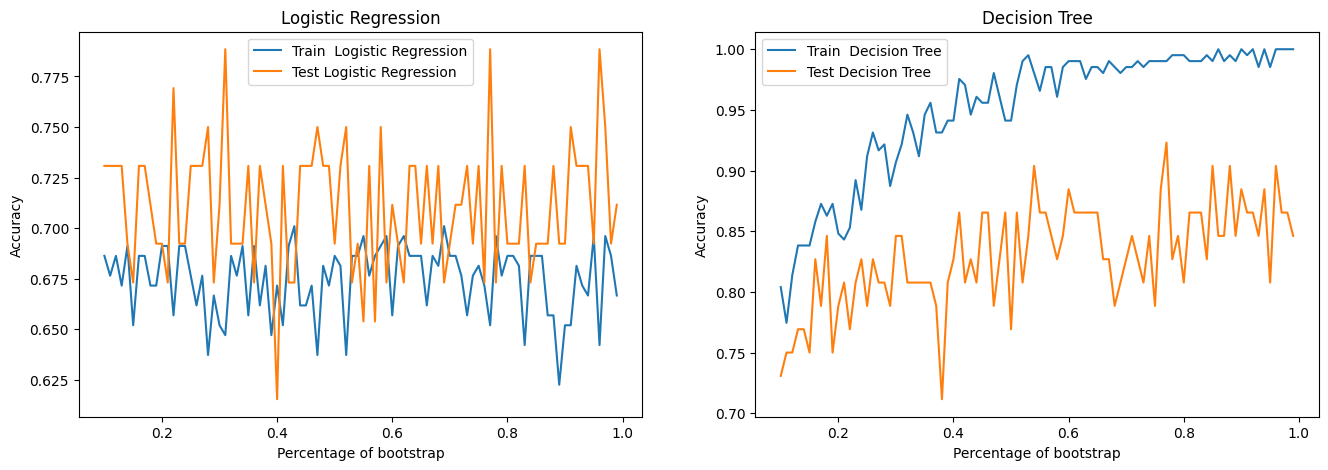

In [ ]:
fig, axs = plt.subplots(1, len(mdls_bag), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls_bag):
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['train' ], label='Train  ' + mdl_name)
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['test']  , label='Test '   + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Percentage of bootstrap')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why the accuracy's cruve is not smooth?
1. Why increasing the size of a bootstrap increases the accuracy in case of decision trees?
1. Why it does not in case of logistic regression?

**Answers**

1. The accuracy curve is not smooth due to the randomness in bootstrapping (random sampling with replacement) and the inherent variability in training multiple models. Smaller bootstrap sizes lead to higher sample diversity, which increases result variance at each evaluation point.

2. Effect of Larger Bootstrap Sizes on Decision Trees: Increasing the bootstrap size improves accuracy because decision trees perform better with more training data. A larger sample allows the model to learn more robust patterns, leading to higher accuracy.

3. Logistic Regression’s Stability: Logistic regression does not benefit significantly from larger bootstraps because it is a stable, low-variance model. Since it is less sensitive to minor changes in training data, increasing the bootstrap size has little effect on its performance.

In [1]:
print('Trees and forests are crucial for life on earth')
print('Not these trees though :)')

Trees and forests are crucial for life on earth
Not these trees though :)
